# Pima model _pycaret

In [13]:
import pandas as pd

## loading the data 


In [14]:
dataset=pd.read_csv('diabetes.csv')

In [15]:
dataset.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [16]:
dataset.shape # we have  768 rows and 9 data columns  


(768, 9)

## EDA

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.offline as py
import plotly.graph_objs as go

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.tools as tls

import plotly.figure_factory as ff
py.init_notebook_mode(connected=True)
import squarify

In [18]:
Diabetic = dataset[(dataset['Outcome'] != 0)]
Non_diabetic = dataset[(dataset['Outcome'] == 0)]


def target_count():
    trace = go.Bar( x = dataset['Outcome'].value_counts().values.tolist(), 
                    y = ['Non_diabetic','diabetic' ], 
                    orientation = 'h', 
                    text=dataset['Outcome'].value_counts().values.tolist(), 
                    textfont=dict(size=15),
                    textposition = 'auto',
                    opacity = 0.8,marker=dict(
                    color=['lightskyblue', 'gold'],
                    line=dict(color='#000000',width=1.5)))

    layout = dict(title =  'Outcome variable')

    fig = dict(data = [trace], layout=layout)
    py.iplot(fig)

In [19]:
target_count()

####  Dataset is clearly unbalanced we can use SMOTE sampling to balance the classes. But In this notebook we are not going to look at it.

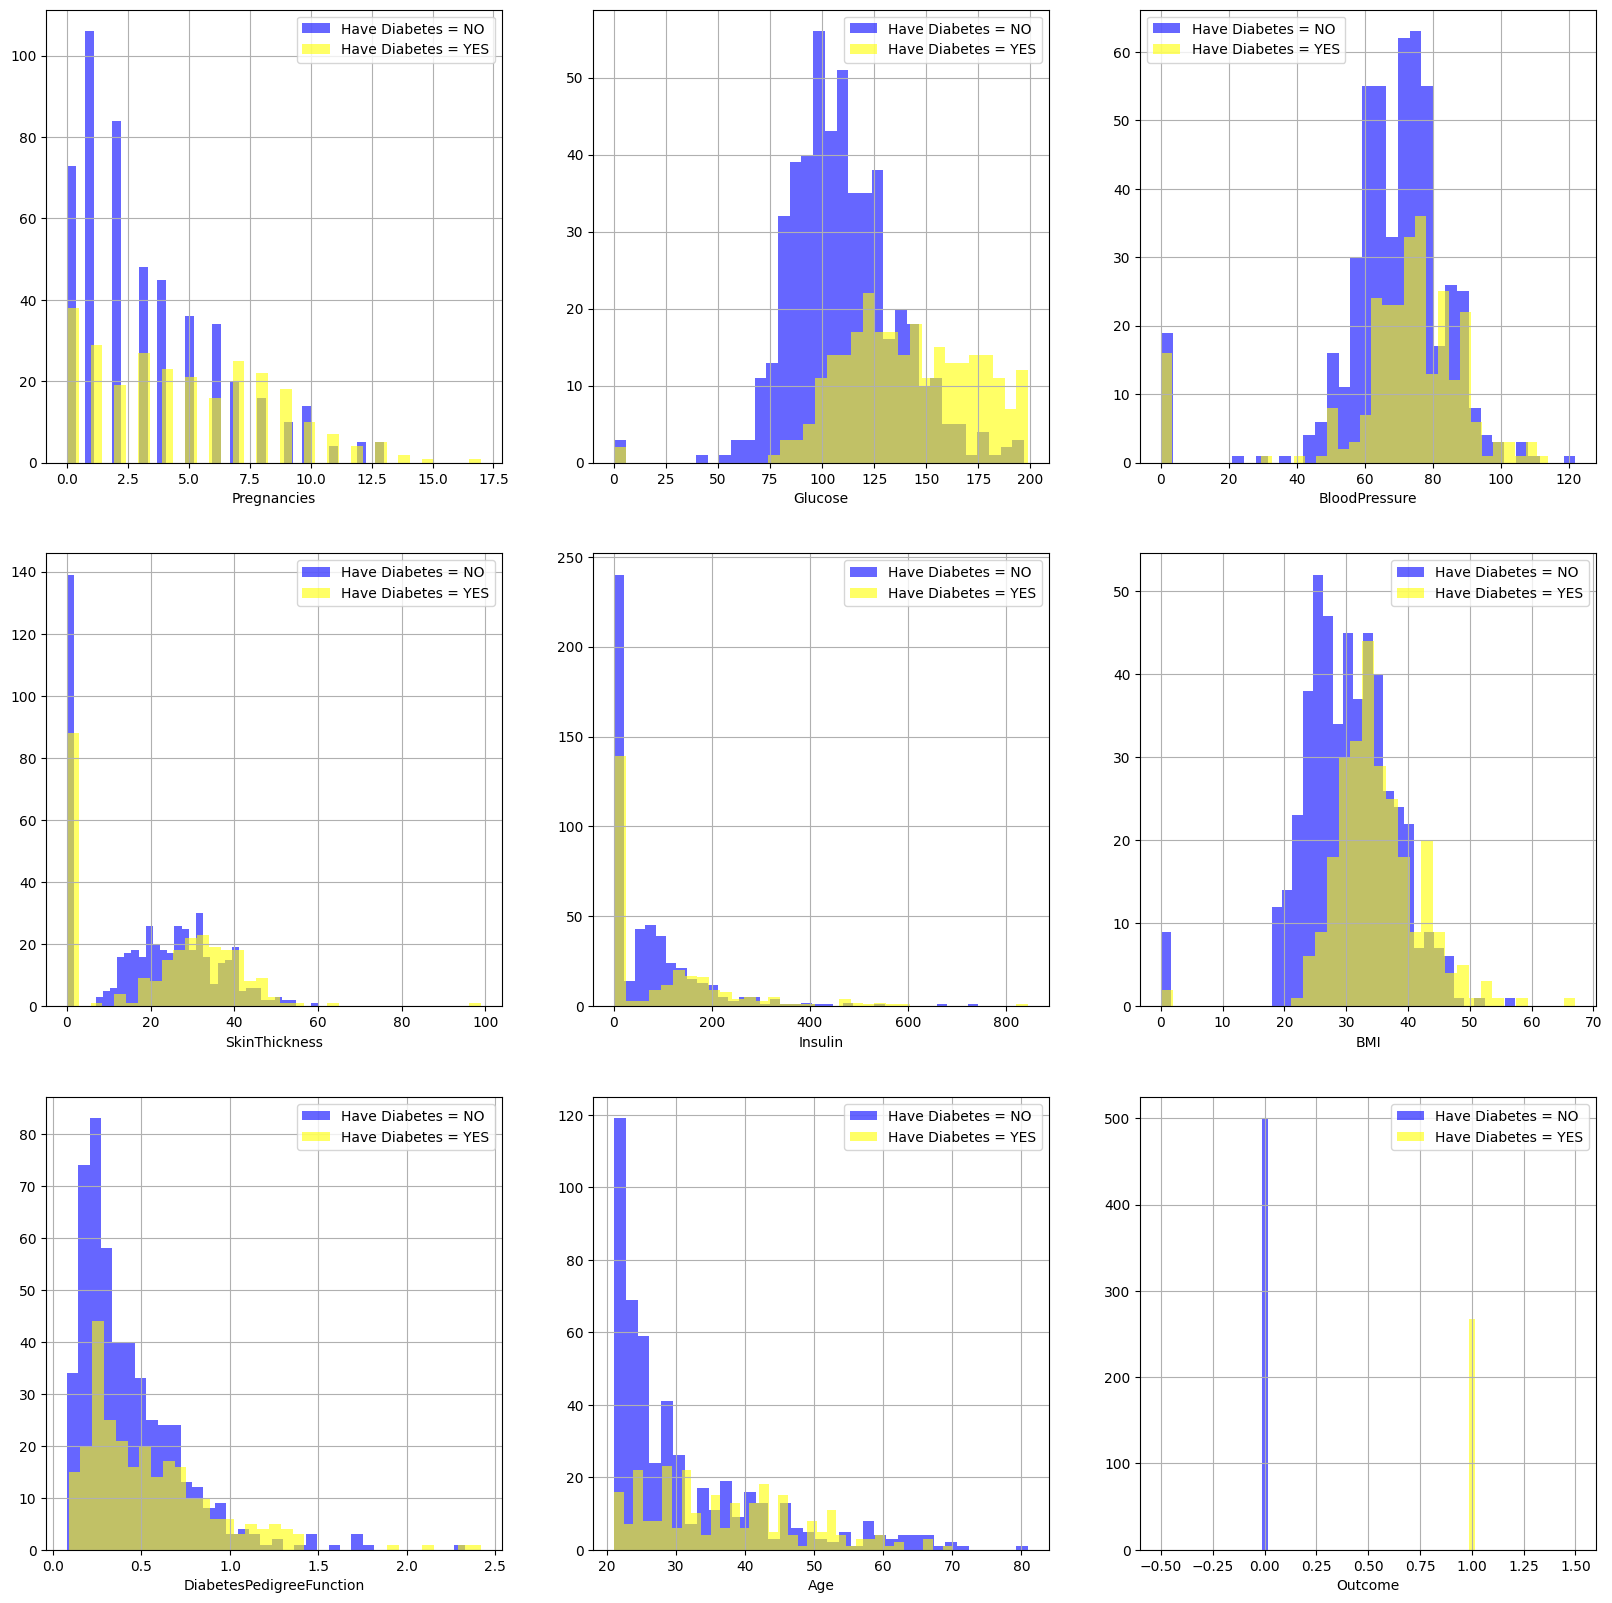

In [20]:
# Visulazing the distibution of the data for every feature
plt.figure(figsize=(20, 20))

for i, column in enumerate(dataset.columns, 1):
    plt.subplot(3, 3, i)
    dataset[dataset["Outcome"] == 0][column].hist(bins=35, color='blue', label='Have Diabetes = NO', alpha=0.6)
    dataset[dataset["Outcome"] == 1][column].hist(bins=35, color='yellow', label='Have Diabetes = YES', alpha=0.6)
    plt.legend()
    plt.xlabel(column)

In [21]:
data = dataset.sample(frac=0.95, random_state=10)

data_unseen = dataset.drop(data.index).reset_index(drop=True)

data.reset_index(drop=True, inplace=True)

print('Data for Modeling: ' + str(data.shape))

print('Unseen Data For Predictions ' + str(data_unseen.shape))

Data for Modeling: (730, 9)
Unseen Data For Predictions (38, 9)


In [22]:
from pycaret.classification import *

In [25]:
clf = setup(data = data, target = 'Outcome',session_id=1229,normalize=True,transformation=True,ignore_low_variance=True,
           remove_multicollinearity=True, multicollinearity_threshold=0.95,folds_shuffle=True)

Setup Succesfully Completed!


,Description,Value
0,session_id,1229
1,Target Type,Binary
2,Label Encoded,None
3,Original Data,"(730, 9)"
4,Missing Values,False
5,Numeric Features,7
6,Categorical Features,1
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


AttributeError: 'Simple_Imputer' object has no attribute 'target_variable'

In [26]:
compare_models(sort='AUC')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
0,CatBoost Classifier,0.7647,0.8336,0.6144,0.6929,0.6478,0.4725,0.4773,2.4407
1,Logistic Regression,0.7569,0.8276,0.5814,0.6854,0.6231,0.4472,0.4545,0.0206
2,Linear Discriminant Analysis,0.7549,0.8193,0.5644,0.6866,0.6150,0.4392,0.4465,0.0069
3,Light Gradient Boosting Machine,0.7510,0.8144,0.5974,0.6662,0.6257,0.4406,0.4453,0.0662
4,Gradient Boosting Classifier,0.7529,0.8087,0.5984,0.6783,0.6312,0.4474,0.4532,0.1131
5,Random Forest Classifier,0.7569,0.8059,0.5307,0.7149,0.6049,0.4352,0.4483,0.0272
6,Extra Trees Classifier,0.7549,0.8014,0.5418,0.6955,0.6060,0.4330,0.4420,0.1231
7,Extreme Gradient Boosting,0.7373,0.7973,0.5758,0.6419,0.6032,0.4087,0.4128,0.1538
8,K Neighbors Classifier,0.7510,0.7874,0.5592,0.6779,0.6068,0.4290,0.4368,0.0024
9,Ada Boost Classifier,0.7373,0.7723,0.5699,0.6475,0.6004,0.4073,0.4129,0.0794


In [43]:
tuned_cat_boost= tune_model(CatBoost,optimize = 'AUC')

NameError: name 'CatBoost' is not defined

### #Lets Create  more classifiers 

In [44]:
lr = create_model('lr', fold =10)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.6863,0.8201,0.6471,0.5238,0.5789,0.3333,0.3381
1,0.7843,0.8215,0.6111,0.7333,0.6667,0.5092,0.5138
2,0.7451,0.7862,0.5556,0.6667,0.6061,0.4199,0.4238
3,0.7647,0.8300,0.4444,0.8000,0.5714,0.4270,0.4620
4,0.6863,0.7508,0.4444,0.5714,0.5000,0.2766,0.2812
5,0.8039,0.7946,0.6667,0.7500,0.7059,0.5596,0.5618
6,0.8627,0.8990,0.8333,0.7895,0.8108,0.7032,0.7039
7,0.7843,0.8906,0.6111,0.7333,0.6667,0.5092,0.5138
8,0.6863,0.8468,0.4444,0.5714,0.5000,0.2766,0.2812
9,0.7647,0.8367,0.5556,0.7143,0.6250,0.4574,0.4651


In [48]:
tuned_lr= tune_model('lr',optimize='AUC') # tuned_logistic   81.6 AUC

SystemExit: (Type Error): The behavior of tune_model in version 1.0.1 is changed. Please pass trained model object.

In [47]:
gbc= create_model('gbc',fold =10) #  Gradient boosting  82.60

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7059,0.7785,0.7059,0.5455,0.6154,0.3836,0.3919
1,0.7843,0.7963,0.6111,0.7333,0.6667,0.5092,0.5138
2,0.7255,0.7845,0.5556,0.6250,0.5882,0.3834,0.3849
3,0.8431,0.8350,0.6667,0.8571,0.7500,0.6383,0.6490
4,0.6863,0.7609,0.5000,0.5625,0.5294,0.2953,0.2965
5,0.8039,0.8098,0.6111,0.7857,0.6875,0.5479,0.5571
6,0.7843,0.8451,0.6667,0.7059,0.6857,0.5217,0.5222
7,0.8235,0.8990,0.6111,0.8462,0.7097,0.5876,0.6037
8,0.6863,0.7727,0.6111,0.5500,0.5789,0.3300,0.3312
9,0.6863,0.8047,0.4444,0.5714,0.5000,0.2766,0.2812


In [50]:
tuned_graident_bosting = tune_model(gbc,optimize='AUC') # tuned Gradient boosting 80.5 

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.6863,0.8010,0.5882,0.5263,0.5556,0.3143,0.3154
1,0.7647,0.8148,0.5556,0.7143,0.6250,0.4574,0.4651
2,0.7451,0.8401,0.6111,0.6471,0.6286,0.4348,0.4352
3,0.8431,0.8182,0.6667,0.8571,0.7500,0.6383,0.6490
4,0.6275,0.7677,0.2778,0.4545,0.3448,0.1053,0.1115
5,0.8039,0.8266,0.6667,0.7500,0.7059,0.5596,0.5618
6,0.8039,0.8215,0.7778,0.7000,0.7368,0.5813,0.5833
7,0.8039,0.8721,0.6111,0.7857,0.6875,0.5479,0.5571
8,0.7255,0.7677,0.5556,0.6250,0.5882,0.3834,0.3849
9,0.8235,0.8266,0.7222,0.7647,0.7429,0.6087,0.6093


In [51]:
xgb = create_model('xgboost',fold =10)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7451,0.7993,0.6471,0.6111,0.6286,0.4348,0.4352
1,0.6667,0.7155,0.4444,0.5333,0.4848,0.2415,0.2437
2,0.8039,0.8434,0.7778,0.7000,0.7368,0.5813,0.5833
3,0.7451,0.8165,0.5000,0.6923,0.5806,0.4043,0.4154
4,0.6667,0.7475,0.4444,0.5333,0.4848,0.2415,0.2437
5,0.8039,0.7929,0.6667,0.7500,0.7059,0.5596,0.5618
6,0.7451,0.7845,0.6667,0.6316,0.6486,0.4489,0.4493
7,0.7647,0.8990,0.5000,0.7500,0.6000,0.4426,0.4609
8,0.6667,0.7441,0.5000,0.5294,0.5143,0.2609,0.2611
9,0.7647,0.8300,0.6111,0.6875,0.6471,0.4715,0.4733


### # lets blend this above models and see if we can beat 82.7 cat boost 

In [52]:
blend_specific_soft = blend_models(estimator_list = [lr,gbc,xgb], method = 'soft')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7059,0.8183,0.5882,0.5556,0.5714,0.3478,0.3482
1,0.7059,0.7643,0.5000,0.6000,0.5455,0.3307,0.3337
2,0.7451,0.8384,0.6111,0.6471,0.6286,0.4348,0.4352
3,0.8039,0.8300,0.6111,0.7857,0.6875,0.5479,0.5571
4,0.6863,0.7677,0.4444,0.5714,0.5000,0.2766,0.2812
5,0.8039,0.8300,0.6667,0.7500,0.7059,0.5596,0.5618
6,0.7843,0.8535,0.7222,0.6842,0.7027,0.5337,0.5341
7,0.7843,0.9007,0.6111,0.7333,0.6667,0.5092,0.5138
8,0.6863,0.7980,0.5556,0.5556,0.5556,0.3131,0.3131
9,0.7843,0.8502,0.6667,0.7059,0.6857,0.5217,0.5222


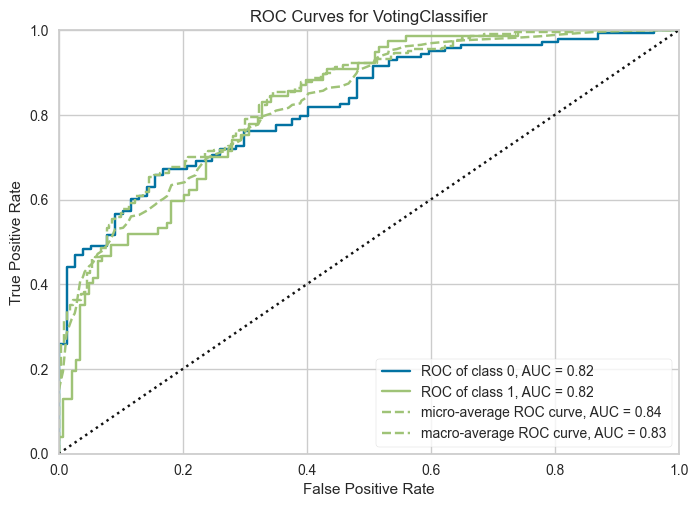

In [53]:
plot_model(blend_specific_soft)

In [54]:
# alright lets make some predictions 
predict_model(blend_specific_soft)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Voting Classifier,0.7273,0.8235,0.5584,0.6232,0.589,0.3859,0.3872


,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Pregnancies_0,Pregnancies_1,Pregnancies_10,...,Pregnancies_3,Pregnancies_4,Pregnancies_5,Pregnancies_6,Pregnancies_7,Pregnancies_8,Pregnancies_9,Outcome,Label,Score
0,-0.924344,-0.588129,0.483538,-0.926680,-0.079997,-1.567942,-0.881624,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0291
1,-0.461501,-0.028745,0.545834,1.723106,0.618963,-1.346161,-0.271174,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0,0.0957
2,0.354176,-0.154616,-0.457685,0.799971,-0.790368,0.388507,-1.232266,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0475
3,1.978946,2.887167,0.296359,-0.926680,0.271549,0.245514,0.927796,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0.8484
4,-1.034162,-1.934750,-0.079549,-0.337960,-0.557492,0.668346,-1.418859,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0366
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215,0.474845,-0.154616,0.171306,0.990961,0.417583,0.618803,-0.137636,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,0,0.4726
216,-0.255875,-0.488651,1.166565,-0.926680,0.258348,-0.655249,-0.881624,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0,0.2163
217,0.073480,-0.383810,0.608084,1.196724,0.271549,-1.029641,0.319285,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0.1857
218,-1.034162,-0.588129,-1.282540,-0.926680,-1.199614,-1.474899,0.319285,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0,0.0432


## Finalizing the model

In [55]:
final_model = finalize_model(blend_specific_soft)

#### # Moment of truth … let’s see how our classifier does if we can predict using the unseen data 

In [56]:
unseen_predictions = predict_model(final_model, data=data_unseen)
unseen_predictions

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,Label,Score
0,2,197,70,45,543,30.5,0.158,53,1,1,0.6751
1,1,189,60,23,846,30.1,0.398,59,1,1,0.6651
2,3,180,64,25,70,34.0,0.271,26,0,1,0.8927
3,7,150,66,42,342,34.7,0.718,42,0,1,0.8754
4,4,129,86,20,270,35.1,0.231,23,0,0,0.1647
5,5,95,72,33,0,37.7,0.370,27,0,0,0.1935
6,2,107,74,30,100,33.6,0.404,23,0,0,0.0945
7,5,132,80,0,0,26.8,0.186,69,0,0,0.1458
8,1,88,30,42,99,55.0,0.496,26,1,0,0.3080
9,2,99,52,15,94,24.6,0.637,21,0,0,0.0321


#### Label and score are added to the data frame. • Label is the predicted outcome • Score is the predicted probability